In [1]:
from numpy import vstack
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor

from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, functional)
from pathlib import Path
from typing import Dict, List, Union
import pandas as pd
import torch
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt


In [2]:
dirPath = Path('C:/william/COMP6721_Applied_AI__Project_Team_AMW')
datasetPath  = Path(dirPath/'dataset')
noMaskPath  = datasetPath/'NoMask'
N95MaskPath = datasetPath/'N95'
clothMaskPath  = datasetPath/'Cloth'
surgicalMaskPath = datasetPath/'Surgical'
N95ValvePath = datasetPath/'N95Valve'
maskDF = pd.DataFrame()

for imagepath in tqdm(list(noMaskPath .iterdir()), desc='no'):
    maskDF = maskDF.append({
        'image': str(imagepath),
        'mask': 0
    }, ignore_index=True)
    
for imagepath in tqdm(list(clothMaskPath .iterdir()), desc='cloth'):
    maskDF = maskDF.append({
        'image': str(imagepath),
        'mask': 1
    }, ignore_index=True)

for imagepath in tqdm(list(N95MaskPath.iterdir()), desc='N95'):
    maskDF = maskDF.append({
        'image': str(imagepath),
        'mask': 2
    }, ignore_index=True)

for imagepath in tqdm(list(surgicalMaskPath.iterdir()), desc='surgical'):
    maskDF = maskDF.append({
        'image': str(imagepath),
        'mask': 3
    }, ignore_index=True)


for imagepath in tqdm(list(N95ValvePath.iterdir()), desc='valve'):
    maskDF = maskDF.append({
        'image': str(imagepath),
        'mask': 4
    }, ignore_index=True)
        

print("Total no. of images:",len(maskDF))
data_frame = datasetPath/'dataset.pickle'
print(f'DataFrame saved successfully: {data_frame}')
maskDF.to_pickle(data_frame)

valve: 100%|███████████████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 1177.34it/s]

Total Number of Images for all Categories: 2069
Saving Dataframe to: C:\william\COMP6721_Applied_AI__Project_Team_AMW\dataset\dataset.pickle


In [3]:
class mask_dataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.3082, 0.2988, 0.3053))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('Supporting Slice')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

In [4]:
                     
class face_mask_detection_CNN(nn.Module):
    def __init__(self):
        super(face_mask_detection_CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 5)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

face_mask_detector_cnn = face_mask_detection_CNN()
print(face_mask_detector_cnn)

face_mask_detection_CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01, inp

In [5]:

def conf_mat(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        print(mask_df['mask'].value_counts())
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        train_folds = []
        val_fold = []
        for train_index, validate_index in skf.split(mask_df, mask_df['mask']):
            train_folds.append(mask_dataset(mask_df.iloc[train_index]))
            val_fold.append(mask_dataset(mask_df.iloc[validate_index]))
        return [ train_folds, val_fold,CrossEntropyLoss() ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)   

train_dfs, validate_dfs, cross_entropy_loss = prepare_data(data_frame)

1.0    435
3.0    420
0.0    410
2.0    402
4.0    402
Name: mask, dtype: int64


In [6]:
epochs = 10
lr = 0.001 
retrain = False

import warnings
warnings.filterwarnings('ignore')

def training(train_fold):
    acc_list = []
    loss_list = []
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=lr)
    for epoch in range(epochs):
        total=0
        correct=0
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_fold), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            loss_list.append(loss.item())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            #training accuracy
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum().item() 
            loss_train += loss
        print('Training Loss after epoch {} : {} Accuracy: {:.2f}%'.format(epoch, loss_train,(correct / total) * 100))

In [7]:

def evaluation(valid_f):
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(valid_f)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)

    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

Running Fold : 1
Training Loss after epoch 0 : 78.04298400878906 Accuracy: 46.94%
Training Loss after epoch 1 : 48.53586959838867 Accuracy: 67.13%
Training Loss after epoch 2 : 39.69739532470703 Accuracy: 75.03%
Training Loss after epoch 3 : 32.74817657470703 Accuracy: 79.54%
Training Loss after epoch 4 : 30.649381637573242 Accuracy: 80.77%
Training Loss after epoch 5 : 23.881853103637695 Accuracy: 85.82%
Training Loss after epoch 6 : 21.47183609008789 Accuracy: 87.16%
Training Loss after epoch 7 : 19.765605926513672 Accuracy: 87.59%
Training Loss after epoch 8 : 14.930459022521973 Accuracy: 90.66%
Training Loss after epoch 9 : 17.65285873413086 Accuracy: 89.15%
Running Fold : 2
Training Loss after epoch 0 : 70.65721893310547 Accuracy: 50.97%
Training Loss after epoch 1 : 48.65007400512695 Accuracy: 69.50%
Training Loss after epoch 2 : 39.27656173706055 Accuracy: 75.99%
Training Loss after epoch 3 : 33.41034698486328 Accuracy: 78.46%
Training Loss after epoch 4 : 29.67180061340332 Accu

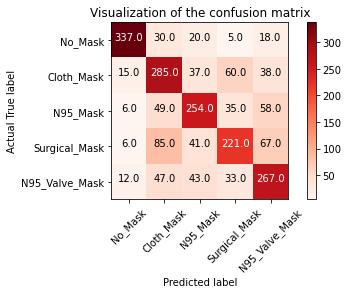

In [8]:
fold_results = []
fold_confusion_matrix = np.zeros((5,5))
classes = ['No_Mask', 'Cloth_Mask', 'N95_Mask', 'Surgical_Mask', 'N95_Valve_Mask']

for index in range(len(train_dfs)):
    print("Running Fold : "+ str(index+1))
    training(train_dfs[index])
    fold_result = evaluation(validate_dfs[index])
    fold_results.append(fold_result[1:-1])
    fold_confusion_matrix = np.add(fold_confusion_matrix,fold_result[0])
    if index != len(train_dfs)-1:
        face_mask_detector_cnn = face_mask_detection_CNN()
#printing the metrics (accuracy,precision,recall,f-scores )and confusion matrix
metrics_df = pd.DataFrame(fold_results, columns=['accuracy', 'precision', 'recall', 'f-score'])
print()
print("Metrics")
print(metrics_df.mean())
print()
print("Across 10-folds")
conf_mat(fold_confusion_matrix, classes)

In [9]:
torch.save(face_mask_detector_cnn, dirPath/'face_mask_detection_CNN.pt')

valve: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 1244.89it/s]


C:\william\COMP6721_Applied_AI__Project_Team_AMW\testDataset\random\test_DataSet (26).jpg
Predicted: N95_Valve_Mask


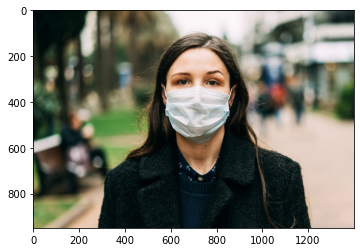

In [10]:
#to predict new images
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "No_Mask",
    1: "Cloth_Mask",
    2: "N95_Mask",
    3: "Surgical_Mask",
    4: "N95_Valve_Mask"
}

def prepare_predict_df():
    testDatasetPath = dirPath/'testDataset' #path to new test data. (not used in training, developement and validation) 
    testRandomPath = testDatasetPath/'random'
    testDF = pd.DataFrame()
    
    for imagepath in tqdm(list(testRandomPath .iterdir()), desc='no'):
        testDF = testDF.append({
            'image': str(imagepath),
            'mask': 0
        }, ignore_index=True)

    for imagepath in tqdm(list(testRandomPath .iterdir()), desc='cloth'):
        testDF = testDF.append({
            'image': str(imagepath),
            'mask': 1
        }, ignore_index=True)

    for imagepath in tqdm(list(testRandomPath.iterdir()), desc='N95'):
        testDF = testDF.append({
            'image': str(imagepath),
            'mask': 2
        }, ignore_index=True)

    for imagepath in tqdm(list(testRandomPath.iterdir()), desc='surgical'):
        testDF = testDF.append({
            'image': str(imagepath),
            'mask': 3
        }, ignore_index=True)

    for imagepath in tqdm(list(testRandomPath.iterdir()), desc='valve'):
        testDF = testDF.append({
            'image': str(imagepath),
            'mask': 4
        }, ignore_index=True)

    return mask_dataset(testDF)

def predict():
    test_df = prepare_predict_df()
    rand_sampler = torch.utils.data.RandomSampler(test_df, num_samples=32, replacement=True)
    data = iter(DataLoader(test_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    rand_ind = random.choice(list(range(0,32)))
    print(data['path'][rand_ind])
    img = Image.open(data['path'][rand_ind])
    plt.imshow(np.asarray(img))
    print("Predicted: ",class_mapping[output[rand_ind].tolist()])

predict()